In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.optimizers import Adam
import tensorflow as tf
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

tf.random.set_seed(13)

# Load data
df = pd.read_csv('/content/Accounts.csv')

# Missing values
cols_with_nan = df.columns[df.isna().any()].tolist()
for col in cols_with_nan:
    if df[col].isna().any():
        df[col] = df.groupby('Class')[col].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Split data
predictors = df.drop(["Account", "Class"], axis=1)
target = df["Class"]

# threshold level
threshold = 0.36

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize lists
all_train_loss = []
all_val_loss = []

for train_index, test_index in skf.split(predictors, target):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train the autoencoder
    autoencoder_epochs = 50
    autoencoder_batch_size = 32

    input_dim = X_train_scaled.shape[1]
    latent_dim = 16

    # Architecture
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256, activation="relu")(input_layer)
    encoded = Dense(128, activation="relu")(encoded)
    encoded = Dense(64, activation="relu")(encoded)
    encoded = Dense(32, activation="relu")(encoded)
    encoded = Dense(16, activation="relu")(encoded)
    decoded = Dense(16, activation="relu")(encoded)
    decoded = Dense(32, activation="relu")(decoded)
    decoded = Dense(64, activation="relu")(decoded)
    decoded = Dense(128, activation="relu")(decoded)
    decoded = Dense(256, activation="relu")(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, decoded)

    # learning rate
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

    # Store training history
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        validation_data=(X_val_scaled, X_val_scaled),
        epochs=autoencoder_epochs,
        batch_size=autoencoder_batch_size,
        verbose=1,
        callbacks=[
            ModelCheckpoint(filepath="./autoencoder_best_model.h5", save_best_only=True, verbose=0),
            EarlyStopping(patience=3)
        ]
    )
    # Append training and validation loss for each fold
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    autoencoder.load_weights("./autoencoder_best_model.h5")

    # Calculate reconstruction errors
    reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

    # Identify anomalies
    anomalies = reconstruction_errors > threshold

    # Evaluate performance
    accuracy_test = accuracy_score(y_test, anomalies)
    precision_test = precision_score(y_test, anomalies)
    recall_test = recall_score(y_test, anomalies)
    f1_test = f1_score(y_test, anomalies)

    # Append scores to the lists
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_test)

# Calculate mean scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

# Print mean performance metrics
print("\nMean Performance Scores Across Folds:")
print("Average Accuracy: %.2f%%" % (mean_accuracy * 100))
print("Average Precision: %.2f%%" % (mean_precision * 100))
print("Average Recall: %.2f%%" % (mean_recall * 100))
print("Average F1-Score: %.2f%%" % (mean_f1 * 100))

Epoch 1/50
127/127 [==============================] - 7s 8ms/step - loss: 0.2023 - val_loss: -2.1813
Epoch 2/50
 21/127 [===>..........................] - ETA: 0s - loss: -4.0055

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -266.6779 - val_loss: -1886.8190
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -44860.0430 - val_loss: -222141.3906
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -2101493.2500 - val_loss: -7418976.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -37046656.0000 - val_loss: -106314840.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -374268448.0000 - val_loss: -922414400.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -2547828992.0000 - val_loss: -5537458688.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -12999534592.0000 - val_loss: -25593907200.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -52444921856.0000 - val_loss: -95308144640.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -1769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -302.2692 - val_loss: -1974.1256
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -50660.3750 - val_loss: -228389.7031
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -2101129.7500 - val_loss: -7147372.5000
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -34969528.0000 - val_loss: -98930096.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -335489376.0000 - val_loss: -817269312.0000
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: -2236686848.0000 - val_loss: -4829894656.0000
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: -11143611392.0000 - val_loss: -21815017472.0000
Epoch 9/50
127/127 [==============================] - 1s 10ms/step - loss: -43821907968.0000 - val_loss: -79905013760.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 9ms/step - loss: -87.9423 - val_loss: -696.6787
Epoch 3/50
127/127 [==============================] - 1s 10ms/step - loss: -38101.1797 - val_loss: -210287.7344
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: -3104867.5000 - val_loss: -12233161.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -75893440.0000 - val_loss: -244947568.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -978106304.0000 - val_loss: -2716812544.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -8155708416.0000 - val_loss: -19817330688.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -47807074304.0000 - val_loss: -103196336128.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -209064394752.0000 - val_loss: -415592742912.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -254.9993 - val_loss: -1778.7271
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -49787.1641 - val_loss: -252648.7188
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -2555020.0000 - val_loss: -9817716.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -52267424.0000 - val_loss: -160945616.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -564610176.0000 - val_loss: -1490064512.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -4058367744.0000 - val_loss: -9425025024.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -21046063104.0000 - val_loss: -44271931392.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -86797148160.0000 - val_loss: -168267137024.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -231.7675 - val_loss: -1549.2163
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -55297.4375 - val_loss: -256097.9219
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -2937082.5000 - val_loss: -10800137.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -64111320.0000 - val_loss: -188971264.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -695599744.0000 - val_loss: -1758348928.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -5013270528.0000 - val_loss: -11160205312.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -26123233280.0000 - val_loss: -52401274880.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -106505510912.0000 - val_loss: -198591479808.0000
Epoch 10/50
127/127 [==============================] - 1s 9ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -236.8585 - val_loss: -1704.8590
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -44981.6562 - val_loss: -225259.8438
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: -2052940.5000 - val_loss: -7829523.5000
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: -39676908.0000 - val_loss: -122516376.0000
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: -410715136.0000 - val_loss: -1091404800.0000
Epoch 7/50
127/127 [==============================] - 1s 8ms/step - loss: -2879793408.0000 - val_loss: -6794633216.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -14925044736.0000 - val_loss: -31673104384.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -59792445440.0000 - val_loss: -117500633088.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -285.6752 - val_loss: -2029.6185
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -52798.4375 - val_loss: -260154.3750
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: -2402328.7500 - val_loss: -8971626.0000
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: -43518884.0000 - val_loss: -132820832.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -441614208.0000 - val_loss: -1164059264.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -3028129024.0000 - val_loss: -7045208576.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -15235979264.0000 - val_loss: -32010139648.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -60289646592.0000 - val_loss: -117465186304.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -19

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -94.7128 - val_loss: -642.5642
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -43048.1055 - val_loss: -212842.9531
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -3545860.2500 - val_loss: -12899589.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -99894128.0000 - val_loss: -284003936.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -1296252544.0000 - val_loss: -3066811392.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -10551395328.0000 - val_loss: -21688580096.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -59988611072.0000 - val_loss: -110856953856.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -262946177024.0000 - val_loss: -449447919616.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -178.0091 - val_loss: -1125.8083
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -46144.0195 - val_loss: -201735.6094
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -2436694.5000 - val_loss: -7984677.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -49640184.0000 - val_loss: -130128264.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -531029440.0000 - val_loss: -1184702080.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -3737466880.0000 - val_loss: -7337716736.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -19104419840.0000 - val_loss: -34119321600.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -77599121408.0000 - val_loss: -127296110592.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -26

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -342.2216 - val_loss: -2372.9639
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -67361.9062 - val_loss: -326638.5000
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -3101296.2500 - val_loss: -11352980.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -58379636.0000 - val_loss: -174140736.0000
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: -613643072.0000 - val_loss: -1566730496.0000
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: -4162544128.0000 - val_loss: -9431681024.0000
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: -21242730496.0000 - val_loss: -43711627264.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -84479033344.0000 - val_loss: -160665845760.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -2

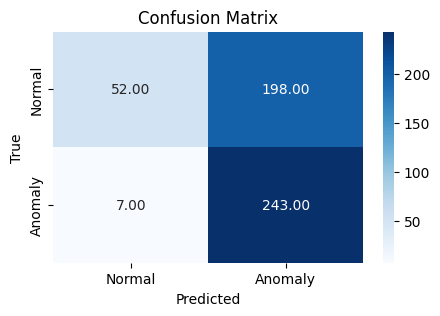

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrices = []
conf_matrix = confusion_matrix(y_test, anomalies)
conf_matrices.append(conf_matrix)

# Calculate average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Plotting average confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

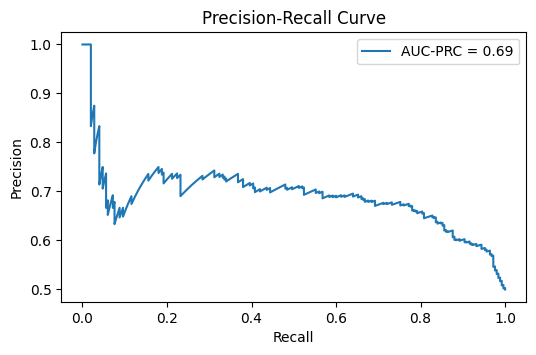

In [18]:
from sklearn.metrics import precision_recall_curve, auc
all_precisions = []
all_recalls = []
num_folds = len(all_train_loss)

plt.figure(figsize=(6, 3.5))
for i in range(num_folds):
    # Calculate precision-recall curve values for the current fold
    precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)

    # Append precision and recall values to the lists
    all_precisions.append(precision)
    all_recalls.append(recall)

# Calculate the mean precision and recall
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)

# Calculate AUC-PRC for the mean curve
auc_prc_mean = auc(mean_recall, mean_precision)

# Plot
plt.plot(mean_recall, mean_precision, label=f'AUC-PRC = {auc_prc_mean:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


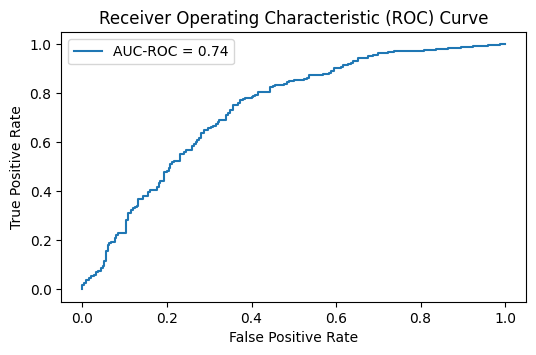

In [19]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)

# Calculate AUC-ROC
auc_roc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 3.5))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


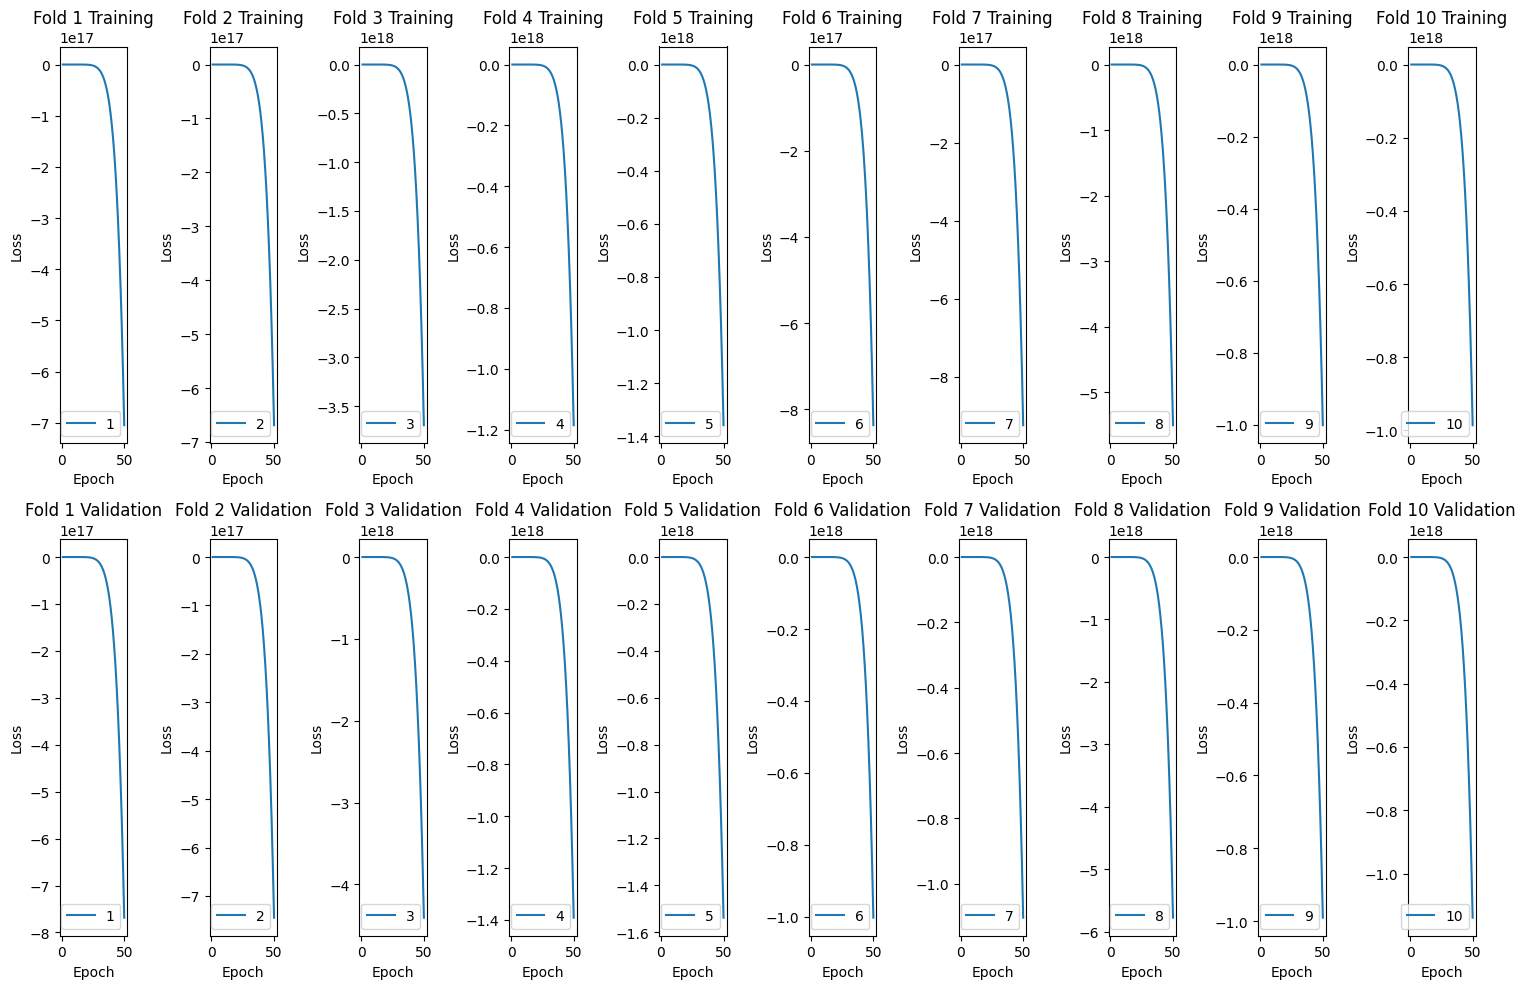

In [20]:
# Number of folds
num_folds = len(all_train_loss)

# Create a separate plot for each fold
plt.figure(figsize=(15, 10))

for i in range(num_folds):
    # Number of epochs for the current fold
    num_epochs_train = len(all_train_loss[i])
    num_epochs_val = len(all_val_loss[i])

   # Plotting training loss
    plt.subplot(2, num_folds, i+1)
    plt.plot(range(1, num_epochs_train + 1), all_train_loss[i], label=f'{i + 1}')
    plt.title(f'Fold {i + 1} Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation loss
    plt.subplot(2, num_folds, i+num_folds+1)
    plt.plot(range(1, num_epochs_val + 1), all_val_loss[i], label=f'{i + 1}')
    plt.title(f'Fold {i + 1} Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


16/16 [==============================] - 0s 2ms/step


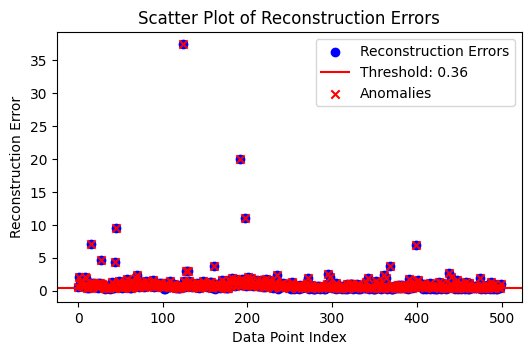

In [21]:
# Calculate reconstruction errors on the test set
reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

# Plotting
plt.figure(figsize=(6, 3.5))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c='blue', label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold: {threshold:.2f}')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], c='red', marker='x', label='Anomalies')
plt.title(f'Scatter Plot of Reconstruction Errors')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


In [22]:
layer_importance_scores = {}

# Iterate over each layer for ablation
for i in range(5):
    layer_scores = []

    for train_index, test_index in skf.split(predictors, target):
        X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        # Standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        autoencoder_epochs = 50
        autoencoder_batch_size = 32

        input_dim = X_train_scaled.shape[1]
        latent_dim = 16

        # Autoencoder architecture
        input_layer = Input(shape=(input_dim,))
        encoded = input_layer

        # Encoder layers with ablation
        for j in range(5):
            if j == i:
                continue
            encoded = Dense(2**(8-j), activation="relu")(encoded)

        decoded = encoded

        # Decoder layers
        for j in reversed(range(5)):
            decoded = Dense(2**(8-j), activation="relu")(decoded)

        decoded = Dense(input_dim, activation="sigmoid")(decoded)

        autoencoder = Model(input_layer, decoded)

        # learning rate
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

        # Store training history
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,
            validation_data=(X_val_scaled, X_val_scaled),
            epochs=autoencoder_epochs,
            batch_size=autoencoder_batch_size,
            verbose=1,
            callbacks=[
                ModelCheckpoint(filepath="./autoencoder_best_model.h5", save_best_only=True, verbose=0),
                EarlyStopping(patience=3)
            ]
        )
        # Append training and validation loss for each fold
        all_train_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        autoencoder.load_weights("./autoencoder_best_model.h5")

        # Calculate reconstruction errors
        reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

        # Identify anomalies
        anomalies = reconstruction_errors > threshold

        # Evaluate performance
        f1_test = f1_score(y_test, anomalies)

        # Append F1 score to the list
        layer_scores.append(f1_test)

    # Calculate mean F1 score across folds for the current layer ablation
    mean_layer_f1 = np.mean(layer_scores)

    # Add mean F1 score to the dictionary
    layer_importance_scores[i] = mean_layer_f1

# Print average importance scores for each layer in descending order
print("\nAverage Importance Scores Across Layers (Descending Order):")
for layer, importance_score in sorted(layer_importance_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"Layer {layer + 1}: {importance_score}")

Epoch 1/50
127/127 [==============================] - 5s 8ms/step - loss: 0.4838 - val_loss: -0.3039
Epoch 2/50
 22/127 [====>.........................] - ETA: 0s - loss: -0.8027

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -29.4287 - val_loss: -168.7804
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -3019.9756 - val_loss: -12854.7637
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -103572.9062 - val_loss: -331654.4375
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -1495236.2500 - val_loss: -3960544.7500
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: -12968132.0000 - val_loss: -29658324.0000
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: -76357168.0000 - val_loss: -154861936.0000
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: -340887200.0000 - val_loss: -629718208.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -1220112128.0000 - val_loss: -2088543232.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -3690567168.0000 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 9ms/step - loss: -9.0778 - val_loss: -53.8437
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -1388.2269 - val_loss: -6176.1338
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -60633.9023 - val_loss: -189553.0156
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -958190.8750 - val_loss: -2462359.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -8589504.0000 - val_loss: -18669548.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -52378800.0000 - val_loss: -100526272.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -237425408.0000 - val_loss: -409402176.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -850613696.0000 - val_loss: -1373738496.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -2622597632.0000 - val_loss: -39

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -14.3999 - val_loss: -93.7907
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -2374.2546 - val_loss: -11129.1689
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -104202.9219 - val_loss: -357656.5312
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -1642839.7500 - val_loss: -4620800.5000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -14593387.0000 - val_loss: -35475492.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -88771744.0000 - val_loss: -192079936.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -404623936.0000 - val_loss: -794772608.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -1472162688.0000 - val_loss: -2699478016.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -4580501504.0000 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -36.7492 - val_loss: -235.1958
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -4592.9282 - val_loss: -21594.0137
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -173469.8125 - val_loss: -619817.3750
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -2757699.0000 - val_loss: -7902740.5000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -24022276.0000 - val_loss: -59244596.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -143460688.0000 - val_loss: -313873728.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -638499136.0000 - val_loss: -1272949504.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -2303756544.0000 - val_loss: -4255569664.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -7005037568.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -24.7443 - val_loss: -151.6803
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -3800.3459 - val_loss: -16666.3750
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -150468.1250 - val_loss: -515641.8125
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -2512796.2500 - val_loss: -6952489.5000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -22290092.0000 - val_loss: -53092052.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -135669792.0000 - val_loss: -286572512.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -612449856.0000 - val_loss: -1172263424.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -2207878656.0000 - val_loss: -3941159168.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -6727216128.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -27.0944 - val_loss: -182.4723
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -3819.4934 - val_loss: -18090.7539
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -139237.4375 - val_loss: -500703.7188
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -2201633.2500 - val_loss: -6403213.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -19129694.0000 - val_loss: -47968828.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -114819480.0000 - val_loss: -256703568.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -518624992.0000 - val_loss: -1047522880.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -1844352896.0000 - val_loss: -3461393664.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -5576501760.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -21.1177 - val_loss: -140.9465
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -3085.6250 - val_loss: -14705.8779
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -124039.9219 - val_loss: -449312.1875
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -2016946.0000 - val_loss: -5938541.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -18344814.0000 - val_loss: -46425416.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -112463424.0000 - val_loss: -251006432.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -508422944.0000 - val_loss: -1025303104.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -1820361472.0000 - val_loss: -3407153408.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -5493448704.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -67.7394 - val_loss: -374.9271
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -7577.2495 - val_loss: -30369.8750
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -247590.7188 - val_loss: -761186.6875
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -3681859.2500 - val_loss: -9409332.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -31594916.0000 - val_loss: -69763568.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -184438912.0000 - val_loss: -363069184.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -827577600.0000 - val_loss: -1482459264.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -2929269504.0000 - val_loss: -4877773824.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -8813329408.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -38.6192 - val_loss: -193.6842
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -3851.0576 - val_loss: -14457.4287
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -127744.4375 - val_loss: -379064.8125
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -1970914.3750 - val_loss: -4768054.5000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -17162072.0000 - val_loss: -35720916.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -102236312.0000 - val_loss: -188924400.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -455043776.0000 - val_loss: -769950400.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -1640042112.0000 - val_loss: -2562964736.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -4999644160.0000 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -10.5206 - val_loss: -63.4956
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -1232.2456 - val_loss: -5441.1655
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -42951.3672 - val_loss: -148496.7500
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -715777.5000 - val_loss: -2080805.1250
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -7131086.5000 - val_loss: -17817942.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -45945228.0000 - val_loss: -101556288.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -221371104.0000 - val_loss: -443868384.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -832607040.0000 - val_loss: -1544078592.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -2642458624.0000 - val_loss: -4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -54.3751 - val_loss: -359.9809
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -8750.7773 - val_loss: -40767.7070
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -384472.2188 - val_loss: -1313060.3750
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -6461719.0000 - val_loss: -17887574.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -60971396.0000 - val_loss: -143476000.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -377690720.0000 - val_loss: -781120576.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -1740045440.0000 - val_loss: -3257507840.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -6352300032.0000 - val_loss: -10980369408.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -19462012928.0000 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -89.0153 - val_loss: -559.1048
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -12966.1484 - val_loss: -57078.1328
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -490856.7812 - val_loss: -1624263.6250
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -7487412.5000 - val_loss: -20492748.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -65682640.0000 - val_loss: -154562576.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -400934176.0000 - val_loss: -836691392.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -1834949376.0000 - val_loss: -3467488000.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -6599064576.0000 - val_loss: -11561236480.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -20043825152.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -72.9914 - val_loss: -456.9618
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -8362.3711 - val_loss: -38730.3320
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -293279.1562 - val_loss: -1028829.5000
Epoch 5/50
127/127 [==============================] - 1s 8ms/step - loss: -4286113.5000 - val_loss: -12435775.0000
Epoch 6/50
127/127 [==============================] - 1s 8ms/step - loss: -36691584.0000 - val_loss: -92451536.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -216729936.0000 - val_loss: -479716384.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -963601408.0000 - val_loss: -1937767168.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -3400064256.0000 - val_loss: -6381338624.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -10220228608.0000 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -62.3079 - val_loss: -390.2248
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -7491.3218 - val_loss: -34266.2812
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -260149.3281 - val_loss: -902265.9375
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -3839995.5000 - val_loss: -10758692.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -31855820.0000 - val_loss: -77182648.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -183632704.0000 - val_loss: -395385600.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -793833024.0000 - val_loss: -1561803520.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -2797244416.0000 - val_loss: -5111706112.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -8355081728.0000 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -118.4807 - val_loss: -704.0776
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -13726.0967 - val_loss: -57210.6484
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -421638.8125 - val_loss: -1385023.0000
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -6019177.0000 - val_loss: -16150984.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -48441336.0000 - val_loss: -112821016.0000
Epoch 7/50
127/127 [==============================] - 1s 8ms/step - loss: -276941760.0000 - val_loss: -576037248.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -1197841920.0000 - val_loss: -2271490816.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -4201929984.0000 - val_loss: -7446005248.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -12558228480.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -59.8517 - val_loss: -395.5346
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -7826.0718 - val_loss: -37694.6094
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -283693.6875 - val_loss: -994007.1250
Epoch 5/50
127/127 [==============================] - 1s 8ms/step - loss: -4112466.0000 - val_loss: -11764744.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -35036336.0000 - val_loss: -85827656.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -203327760.0000 - val_loss: -443043232.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -888538048.0000 - val_loss: -1763769728.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -3121661696.0000 - val_loss: -5774602240.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -9447179264.0000 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -94.4074 - val_loss: -641.3754
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -14341.9834 - val_loss: -67878.4141
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -543318.8750 - val_loss: -1926161.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -8184407.0000 - val_loss: -23562840.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -69734704.0000 - val_loss: -173145728.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -406399968.0000 - val_loss: -893498176.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -1772193152.0000 - val_loss: -3536276736.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -6185605632.0000 - val_loss: -11486321664.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -18310338560.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -36.5902 - val_loss: -203.3961
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -4100.3525 - val_loss: -16205.0449
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -125195.3047 - val_loss: -377881.5625
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -1785847.6250 - val_loss: -4519882.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -15062301.0000 - val_loss: -33087738.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -87438600.0000 - val_loss: -171864464.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -392891488.0000 - val_loss: -704000896.0000
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: -1398239488.0000 - val_loss: -2332916224.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -4249904384.0000 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -61.2307 - val_loss: -325.1043
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -8538.1758 - val_loss: -33744.3281
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -333679.3750 - val_loss: -1016682.2500
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -5569082.0000 - val_loss: -13627392.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -50373028.0000 - val_loss: -105536656.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -306976672.0000 - val_loss: -569054016.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -1384098944.0000 - val_loss: -2346383616.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -5034227200.0000 - val_loss: -7872931840.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -15432999936.0000 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -125.9499 - val_loss: -785.5529
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -15361.1934 - val_loss: -67811.4766
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -507576.5000 - val_loss: -1719000.3750
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -7459730.0000 - val_loss: -20727240.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -64050276.0000 - val_loss: -153565280.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -369188992.0000 - val_loss: -790822464.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -1638347776.0000 - val_loss: -3206934528.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -5793474048.0000 - val_loss: -10529541120.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -17466013696.000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -105.8355 - val_loss: -608.2580
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -10486.5898 - val_loss: -44429.2031
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -341871.4688 - val_loss: -1084568.2500
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -4715272.0000 - val_loss: -12314750.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -38886452.0000 - val_loss: -87599656.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -219300160.0000 - val_loss: -439132672.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -945967552.0000 - val_loss: -1728967680.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -3294715392.0000 - val_loss: -5589907968.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -9746610176.0000 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -33.1376 - val_loss: -197.8523
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -4589.6455 - val_loss: -20646.4863
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -183894.7344 - val_loss: -580201.1250
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -2745018.7500 - val_loss: -7199468.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -24007464.0000 - val_loss: -53029560.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -141278448.0000 - val_loss: -277608352.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -626728000.0000 - val_loss: -1102167296.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -2209835520.0000 - val_loss: -3647994368.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -6724277248.0000 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -73.3352 - val_loss: -454.6180
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -11248.6543 - val_loss: -49640.3516
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -453312.9688 - val_loss: -1458041.6250
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -7091312.0000 - val_loss: -18498850.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -62311732.0000 - val_loss: -139697504.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -373776672.0000 - val_loss: -747167488.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -1640821120.0000 - val_loss: -2942307840.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -5826833408.0000 - val_loss: -9730420736.0000
Epoch 10/50
127/127 [==============================] - 1s 8ms/step - loss: -17721360384.0000 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 9ms/step - loss: -112.6132 - val_loss: -730.4944
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -15270.5928 - val_loss: -70729.6406
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -549841.5000 - val_loss: -1918540.5000
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -8300139.5000 - val_loss: -23436832.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -70322568.0000 - val_loss: -171517088.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -411914080.0000 - val_loss: -891185536.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -1801880448.0000 - val_loss: -3558769664.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -6408671744.0000 - val_loss: -11753934848.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -19292444672.000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -365.4814 - val_loss: -2232.1116
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -45986.8477 - val_loss: -195206.8594
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -1468292.1250 - val_loss: -4903729.0000
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: -21694526.0000 - val_loss: -59086376.0000
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: -180344688.0000 - val_loss: -426636640.0000
Epoch 7/50
127/127 [==============================] - 1s 8ms/step - loss: -1066304064.0000 - val_loss: -2249040384.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -4725662720.0000 - val_loss: -9062231040.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -16883673088.0000 - val_loss: -30178729984.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -512032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -149.5569 - val_loss: -990.5323
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -20456.7402 - val_loss: -97138.8203
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -734314.5000 - val_loss: -2640055.7500
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -11493885.0000 - val_loss: -33464612.0000
Epoch 6/50
127/127 [==============================] - 1s 8ms/step - loss: -99726720.0000 - val_loss: -250915808.0000
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: -602568768.0000 - val_loss: -1354079232.0000
Epoch 8/50
127/127 [==============================] - 1s 10ms/step - loss: -2749716224.0000 - val_loss: -5582861312.0000
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: -9875674112.0000 - val_loss: -18623625216.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -30125897728

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -304.3672 - val_loss: -1963.2921
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -36825.1484 - val_loss: -166925.4688
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -1205667.2500 - val_loss: -4140023.0000
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -16668109.0000 - val_loss: -46913588.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -135016256.0000 - val_loss: -329949792.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -761538624.0000 - val_loss: -1655695616.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -3243777792.0000 - val_loss: -6414500352.0000
Epoch 9/50
127/127 [==============================] - 1s 9ms/step - loss: -11137823744.0000 - val_loss: -20546588672.0000
Epoch 10/50
127/127 [==============================] - 1s 10ms/step - loss: -3260624

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -186.9014 - val_loss: -1092.1851
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -26166.2734 - val_loss: -107366.1719
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -913439.9375 - val_loss: -2827929.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -13819458.0000 - val_loss: -35320092.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -118739416.0000 - val_loss: -261682352.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -691622400.0000 - val_loss: -1359264000.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -3097977600.0000 - val_loss: -5543824896.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -10967352320.0000 - val_loss: -18258497536.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -330400747

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 10ms/step - loss: -109.7137 - val_loss: -594.8213
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: -15752.4111 - val_loss: -61961.4844
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -599904.5625 - val_loss: -1810454.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -9741951.0000 - val_loss: -23631608.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -86348504.0000 - val_loss: -179660592.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -518872800.0000 - val_loss: -956877312.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -2317304064.0000 - val_loss: -3912892160.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -8362648576.0000 - val_loss: -13026682880.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -25454016512.00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -140.6285 - val_loss: -965.3588
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -23232.0762 - val_loss: -108543.0547
Epoch 4/50
127/127 [==============================] - 1s 7ms/step - loss: -897316.2500 - val_loss: -3147125.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -14283894.0000 - val_loss: -40662108.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -128524944.0000 - val_loss: -312675488.0000
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: -759223424.0000 - val_loss: -1642262016.0000
Epoch 8/50
127/127 [==============================] - 1s 9ms/step - loss: -3419900928.0000 - val_loss: -6747010560.0000
Epoch 9/50
127/127 [==============================] - 1s 7ms/step - loss: -12234280960.0000 - val_loss: -22384412672.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -3723459379

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -296.2466 - val_loss: -1817.8507
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -36798.6172 - val_loss: -159099.8438
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -1281928.0000 - val_loss: -4074961.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -17987838.0000 - val_loss: -46948188.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -149791984.0000 - val_loss: -336774240.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -847946560.0000 - val_loss: -1693127552.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -3659974912.0000 - val_loss: -6669019136.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -12738498560.0000 - val_loss: -21542012928.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -37630914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -212.4898 - val_loss: -1270.8425
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -26957.1836 - val_loss: -111683.1406
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -895652.3750 - val_loss: -2812409.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -12403300.0000 - val_loss: -32545694.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -101533576.0000 - val_loss: -231013584.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -588425472.0000 - val_loss: -1194109696.0000
Epoch 8/50
127/127 [==============================] - 1s 7ms/step - loss: -2586663936.0000 - val_loss: -4777741824.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -9031169024.0000 - val_loss: -15533206528.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -2682737049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -331.8212 - val_loss: -2303.4775
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -51829.7852 - val_loss: -250352.4688
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: -1980878.3750 - val_loss: -7074776.5000
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -29749214.0000 - val_loss: -86997096.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -256343664.0000 - val_loss: -648394176.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1514256128.0000 - val_loss: -3358466304.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -6722570240.0000 - val_loss: -13537396736.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -23670859776.0000 - val_loss: -44469714944.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -709492

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -200.7687 - val_loss: -1338.1140
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -34102.1055 - val_loss: -163275.6094
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -1388667.7500 - val_loss: -4950894.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -22332778.0000 - val_loss: -63952576.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -196573360.0000 - val_loss: -484055456.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1180214272.0000 - val_loss: -2568739072.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -5248416256.0000 - val_loss: -10409059328.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -18879711232.0000 - val_loss: -34744590336.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -573039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -106.2151 - val_loss: -668.1988
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -18435.7793 - val_loss: -81220.7891
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -727561.6875 - val_loss: -2492220.7500
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -12248210.0000 - val_loss: -33897864.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -109351416.0000 - val_loss: -260663888.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -670522176.0000 - val_loss: -1419200512.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -3061288960.0000 - val_loss: -5878766080.0000
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: -11168687104.0000 - val_loss: -20001536000.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -34392600576

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -109.4106 - val_loss: -824.7601
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -23052.4336 - val_loss: -114962.0469
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: -961084.0625 - val_loss: -3541549.7500
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -16067290.0000 - val_loss: -47315964.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -142787344.0000 - val_loss: -360021152.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -863582400.0000 - val_loss: -1935845504.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -3914598400.0000 - val_loss: -7923943424.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -13957424128.0000 - val_loss: -26237310976.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -4226954854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -217.2063 - val_loss: -1508.1721
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -34035.3008 - val_loss: -160476.2344
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -1270566.7500 - val_loss: -4493732.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -19076560.0000 - val_loss: -54925464.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -163149440.0000 - val_loss: -406088768.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -958425792.0000 - val_loss: -2113042560.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -4207008512.0000 - val_loss: -8405356032.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -14733740032.0000 - val_loss: -27377000448.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -43687161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -196.7456 - val_loss: -1077.2522
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -20534.3535 - val_loss: -80584.7656
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -625343.7500 - val_loss: -1888670.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -8952141.0000 - val_loss: -22702312.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -76076976.0000 - val_loss: -167954112.0000
Epoch 7/50
127/127 [==============================] - 1s 7ms/step - loss: -448084928.0000 - val_loss: -886035776.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -2043467392.0000 - val_loss: -3683525376.0000
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: -7369947136.0000 - val_loss: -12360837120.0000
Epoch 10/50
127/127 [==============================] - 1s 7ms/step - loss: -22604050432.00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 7ms/step - loss: -236.4132 - val_loss: -1298.8254
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -33790.4180 - val_loss: -131446.2812
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: -1225293.6250 - val_loss: -3670802.7500
Epoch 5/50
127/127 [==============================] - 1s 7ms/step - loss: -19626094.0000 - val_loss: -47631308.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -174219776.0000 - val_loss: -363331488.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1051548544.0000 - val_loss: -1944541056.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -4717854208.0000 - val_loss: -7985995776.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -17089471488.0000 - val_loss: -26679234560.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -5218212

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -392.2808 - val_loss: -2455.8682
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -45073.5898 - val_loss: -196168.6562
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -1390384.6250 - val_loss: -4629209.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -19371526.0000 - val_loss: -53167248.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -160990592.0000 - val_loss: -382574752.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -906542848.0000 - val_loss: -1927407488.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -3951791616.0000 - val_loss: -7696646144.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -13813852160.0000 - val_loss: -25021702144.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -41335066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -298.3637 - val_loss: -1812.5228
Epoch 3/50
127/127 [==============================] - 1s 5ms/step - loss: -37902.5469 - val_loss: -164080.8594
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -1369375.6250 - val_loss: -4385399.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -19964042.0000 - val_loss: -52675592.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -172908592.0000 - val_loss: -392784448.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1010272320.0000 - val_loss: -2035115520.0000
Epoch 8/50
127/127 [==============================] - 1s 8ms/step - loss: -4472419840.0000 - val_loss: -8209091072.0000
Epoch 9/50
127/127 [==============================] - 1s 8ms/step - loss: -15881003008.0000 - val_loss: -27010856960.0000
Epoch 10/50
127/127 [==============================] - 1s 8ms/step - loss: -4766216

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -247.3927 - val_loss: -1716.8480
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -60595.5586 - val_loss: -286932.4375
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: -3076287.0000 - val_loss: -10650512.0000
Epoch 5/50
127/127 [==============================] - 1s 8ms/step - loss: -54473284.0000 - val_loss: -153357824.0000
Epoch 6/50
127/127 [==============================] - 1s 7ms/step - loss: -520285344.0000 - val_loss: -1244426368.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -3343880960.0000 - val_loss: -7043724288.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -15802216448.0000 - val_loss: -30026127360.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -58045763584.0000 - val_loss: -102074359808.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -587.5393 - val_loss: -3820.7786
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -75119.5078 - val_loss: -348593.0625
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -2619145.7500 - val_loss: -9115452.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -37447332.0000 - val_loss: -107830744.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -315522144.0000 - val_loss: -790480832.0000
Epoch 7/50
127/127 [==============================] - 1s 5ms/step - loss: -1846361344.0000 - val_loss: -4077301504.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -8196410368.0000 - val_loss: -16473465856.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -28957530112.0000 - val_loss: -54340292608.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -87166

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -47.2419 - val_loss: -301.3769
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -6638.3794 - val_loss: -31137.2520
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -295607.8125 - val_loss: -1132390.5000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -6476804.5000 - val_loss: -20482784.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -75559864.0000 - val_loss: -201875552.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -558349504.0000 - val_loss: -1291355264.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -2875965184.0000 - val_loss: -5967379968.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -11550396416.0000 - val_loss: -21979398144.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -38080557056.000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -564.2927 - val_loss: -3763.6470
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -108362.9062 - val_loss: -491178.1562
Epoch 4/50
127/127 [==============================] - 1s 6ms/step - loss: -4391720.0000 - val_loss: -15334548.0000
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -74088496.0000 - val_loss: -207223920.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -660590912.0000 - val_loss: -1583948032.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -4041987072.0000 - val_loss: -8574586368.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -18237749248.0000 - val_loss: -35043176448.0000
Epoch 9/50
127/127 [==============================] - 1s 9ms/step - loss: -65785950208.0000 - val_loss: -117712281600.0000
Epoch 10/50
127/127 [==============================] - 1s 8ms/step - loss: -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -236.4348 - val_loss: -1690.1484
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -41418.0508 - val_loss: -202263.4375
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: -1646802.0000 - val_loss: -6077919.5000
Epoch 5/50
127/127 [==============================] - 1s 8ms/step - loss: -27901882.0000 - val_loss: -82807008.0000
Epoch 6/50
127/127 [==============================] - 1s 8ms/step - loss: -253401136.0000 - val_loss: -644903296.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1567485056.0000 - val_loss: -3542740736.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -7229516800.0000 - val_loss: -14712832000.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -26067476480.0000 - val_loss: -49208819712.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -796231

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -334.9211 - val_loss: -2448.5586
Epoch 3/50
127/127 [==============================] - 1s 8ms/step - loss: -67010.1875 - val_loss: -329109.6875
Epoch 4/50
127/127 [==============================] - 1s 8ms/step - loss: -2856026.2500 - val_loss: -10395761.0000
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -46322396.0000 - val_loss: -136160688.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -416186688.0000 - val_loss: -1052196480.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -2530337280.0000 - val_loss: -5643016192.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -11378704384.0000 - val_loss: -22929723392.0000
Epoch 9/50
127/127 [==============================] - 1s 5ms/step - loss: -40532279296.0000 - val_loss: -75802927104.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 6ms/step - loss: -345.7363 - val_loss: -2167.6687
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -62661.3984 - val_loss: -267404.4375
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -2457894.2500 - val_loss: -7789217.0000
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -39503568.0000 - val_loss: -102435480.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -350788128.0000 - val_loss: -780068160.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -2081876480.0000 - val_loss: -4113515264.0000
Epoch 8/50
127/127 [==============================] - 1s 6ms/step - loss: -9417993216.0000 - val_loss: -16899465216.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -33467701248.0000 - val_loss: -55773736960.0000
Epoch 10/50
127/127 [==============================] - 1s 5ms/step - loss: -10089

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 5ms/step - loss: -300.6974 - val_loss: -1715.0873
Epoch 3/50
127/127 [==============================] - 1s 6ms/step - loss: -50365.1094 - val_loss: -202416.0938
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -2025084.6250 - val_loss: -6181377.5000
Epoch 5/50
127/127 [==============================] - 1s 5ms/step - loss: -33725876.0000 - val_loss: -82547544.0000
Epoch 6/50
127/127 [==============================] - 1s 6ms/step - loss: -303985760.0000 - val_loss: -636419200.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -1847494144.0000 - val_loss: -3425479168.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -8326382080.0000 - val_loss: -14119447552.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -30252228608.0000 - val_loss: -47291768832.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -925661

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 1s 8ms/step - loss: -843.8431 - val_loss: -5642.9937
Epoch 3/50
127/127 [==============================] - 1s 7ms/step - loss: -124333.7969 - val_loss: -562740.5000
Epoch 4/50
127/127 [==============================] - 1s 5ms/step - loss: -4307207.0000 - val_loss: -14665091.0000
Epoch 5/50
127/127 [==============================] - 1s 6ms/step - loss: -63512156.0000 - val_loss: -176534784.0000
Epoch 6/50
127/127 [==============================] - 1s 5ms/step - loss: -542567232.0000 - val_loss: -1297580800.0000
Epoch 7/50
127/127 [==============================] - 1s 6ms/step - loss: -3095724288.0000 - val_loss: -6603906560.0000
Epoch 8/50
127/127 [==============================] - 1s 5ms/step - loss: -13573515264.0000 - val_loss: -26461235200.0000
Epoch 9/50
127/127 [==============================] - 1s 6ms/step - loss: -47496626176.0000 - val_loss: -86031261696.0000
Epoch 10/50
127/127 [==============================] - 1s 6ms/step - loss: -1